In [6]:
import numpy as np
from matplotlib import pyplot as plt
import py_gauge_mc

In [7]:
def make_graph(l=4, inv_k=1/2.0,vlen=100):
    graph = py_gauge_mc.GaugeTheory(l,l,l,l,[(n**2)*inv_k for n in range(vlen)])
    return graph

In [8]:
inv_ks = np.linspace(0.25,3.0, 20)
windings = []

for inv_k in inv_ks:
    g = make_graph(l=4, inv_k=inv_k, vlen=30)
    winding_var = g.simulate_and_get_winding_variance(1000,10)
    windings.append(winding_var.mean())

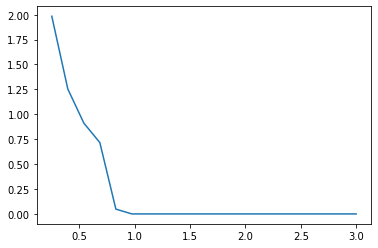

In [9]:
plt.plot(inv_ks, windings)
plt.show()